This notebook is part of the $\omega radlib$  documentation: http://docs.wradlib.org.

Copyright (c) 2018, $\omega radlib$  developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Converting Reflectivity to Rainfall

Reflectivity (Z) and precipitation rate (R) can be related in form of a power law $Z=a \cdot R^b$. The parameters ``a`` and ``b`` depend on the type of precipitation (i.e. drop size distribution and water temperature). $\omega radlib$ provides a couple of functions that could be useful in this context.

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

/home/travis/miniconda/envs/wradlib/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The following example demonstrates the steps to convert from the common unit *dBZ* (decibel of the reflectivity factor *Z*) to rainfall intensity (in the unit of mm/h). This is an array of typical reflectivity values (**unit: dBZ**)

In [2]:
dBZ = np.array([20., 30., 40., 45., 50., 55.])
print(dBZ)

[20. 30. 40. 45. 50. 55.]


Convert to reflectivity factor Z (**unit**: $mm^6/m^3$):

In [3]:
Z = wrl.trafo.idecibel(dBZ)
print(Z)

[1.00000000e+02 1.00000000e+03 1.00000000e+04 3.16227766e+04
 1.00000000e+05 3.16227766e+05]


Convert to rainfall intensity (**unit: mm/h**) using the Marshall-Palmer Z(R) parameters:

In [4]:
R = wrl.zr.z_to_r(Z, a=200., b=1.6)
print(np.round(R, 2))

[ 0.65  2.73 11.53 23.68 48.62 99.85]


Convert to rainfall depth (**unit: mm**) assuming a rainfall duration of five minutes (i.e. 300 seconds)

In [5]:
depth = wrl.trafo.r_to_depth(R, 300)
print(np.round(depth, 2))

[0.05 0.23 0.96 1.97 4.05 8.32]


## An example with real radar data

The following example is based on observations of the DWD C-band radar on mount Feldberg (SW-Germany).
The figure shows a 15 minute accumulation of rainfall which was produced from three consecutive radar
scans at 5 minute intervals between 17:30 and 17:45 on June 8, 2008.

The radar data are read using [wradlib.io.read_dx](http://docs.wradlib.org/en/latest/generated/wradlib.io.radolan.read_dx.html) function which returns an array of dBZ values and a metadata dictionary (see also [Reading-DX-Data](../fileio/wradlib_reading_dx.ipynb#Reading-DX-Data)). The conversion is carried out the same way as in the example above. The plot is produced using
the function [wradlib.vis.plot_ppi](http://docs.wradlib.org/en/latest/generated/wradlib.vis.plot_ppi.html).

In [6]:
def read_data(dtimes):
    """Helper function to read raw data for a list of datetimes <dtimes>
    """
    data = np.empty((len(dtimes),360,128))
    for i, dtime in enumerate(dtimes):
        f = wrl.util.get_wradlib_data_file('dx/raa00-dx_10908-{0}-fbg---bin.gz'.format(dtime))
        data[i], attrs = wrl.io.read_dx(f)
    return data

Read data from radar Feldberg for three consecutive 5 minute intervals and compute the accumulated rainfall depth.

In [7]:
# Read
dtimes = ["0806021735","0806021740","0806021745"]
dBZ = read_data(dtimes)
# Convert to rainfall intensity (mm/h)
Z = wrl.trafo.idecibel(dBZ)
R = wrl.zr.z_to_r(Z, a=200., b=1.6)
# Convert to rainfall depth (mm)
depth = wrl.trafo.r_to_depth(R, 300)
# Accumulate 15 minute rainfall depth over all three 5 minute intervals
accum = np.sum(depth, axis=0)

Plot PPI of 15 minute rainfall depth

<Figure size 720x576 with 0 Axes>

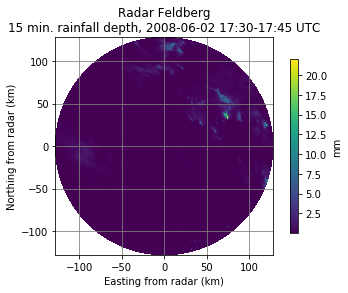

In [8]:
pl.figure(figsize=(10,8))
ax, cf = wrl.vis.plot_ppi(accum, cmap="viridis")
pl.xlabel("Easting from radar (km)")
pl.ylabel("Northing from radar (km)")
pl.title("Radar Feldberg\n15 min. rainfall depth, 2008-06-02 17:30-17:45 UTC")
cb = pl.colorbar(cf, shrink=0.8)
cb.set_label("mm")
pl.xlim(-128,128)
pl.ylim(-128,128)
pl.grid(color="grey")